In [1]:
import data
import glob
import matplotlib.pyplot as plt
import models
import numpy as np
import os
import pandas as pd
import pypickle
import strategy
import time

from data import * 
from feature_engineering import FeaturesEngineering
from models import Models
from io import StringIO
from IPython.display import display
from sklearn.linear_model import LassoCV
from utils import log

2025-03-01 21:03:59.210645: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 21:03:59.220593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740834239.232703  796337 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740834239.236475  796337 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 21:03:59.249047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
models = Models(use_xgboost_gpu=True)

# Initializing the FeaturesEngineering obj
feat = FeaturesEngineering()
# Default config
feat.default_config

dict_data = {}
dict_cv_features = {}

In [3]:
dir_project = os.getcwd()
dir_models = os.path.join(dir_project, 'models')
dir_models_base = os.path.join(dir_project, 'models', 'base')
dir_models_scaler = os.path.join(dir_project, 'models', 'scaler')
dir_models_best = os.path.join(dir_project, 'models', 'best')

print(f"""
Project directory: {dir_project}
Models directory: {dir_models}
Base models directory: {dir_models_base}
Scalers directory: {dir_models_scaler}
Best models directory: {dir_models_best}
""")


Project directory: /home/alfred/projects/mscfe-masters-project/src
Models directory: /home/alfred/projects/mscfe-masters-project/src/models
Base models directory: /home/alfred/projects/mscfe-masters-project/src/models/base
Scalers directory: /home/alfred/projects/mscfe-masters-project/src/models/scaler
Best models directory: /home/alfred/projects/mscfe-masters-project/src/models/best



# Read raw data

In [4]:
# Define S3 bucket and file path
bucket_name = 'mscfe-capstone-project-bucket'
file_key = 'filtered_data.csv'

filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)
display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,AMZN,BNBUSDT,0.877059,-3.631203,0.005192,True,-3.545100,0.028601,True
3,AMZN,TRXUSDT,0.814577,-3.869803,0.002269,True,-3.387413,0.043768,True
4,SPY_ETF,AVAXUSDT,0.847292,-3.309927,0.014441,True,-3.698512,0.018406,True
5,SPY_ETF,ETHUSDT,0.862483,-3.428205,0.010034,True,-3.737367,0.016394,True
6,EQQQ_ETF,BNBUSDT,0.886060,-3.816404,0.002744,True,-3.670509,0.019987,True
7,BNBUSDT,ADAUSDT,0.901459,-3.279504,0.015820,True,-3.775562,0.014607,True
8,BNBUSDT,BTCUSDT,0.884604,-2.909961,0.044202,True,-3.393160,0.043116,True
9,BNBUSDT,TRXUSDT,0.933562,-3.656380,0.004770,True,-4.003675,0.007095,True


In [5]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
file_key = 'df_full_test.csv'
df_full = pd.read_csv(file_key).drop(['Unnamed: 0'], axis=1)
# obj = s3.get_object(Bucket=bucket_name, Key=file_key)
# df_full = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
AMZN BNBUSDT
AMZN TRXUSDT
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT BTCUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
********************
Unique tickers:
META
AMZN
SPY_ETF
EQQQ_ETF
BNBUSDT
DAXEX_ETF
TRXUSDT
AVAXUSDT
ETHUSDT
ADAUSDT
BTCUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
32407,2025-01-28 02:40:00,240.32000,240.65000,240.00000,240.12000,SOLUSDT
30365,2025-01-27 09:40:00,0.32398,0.32418,0.32235,0.32257,DOGEUSDT
24353,2025-01-25 07:35:00,684.20000,684.24000,684.10000,684.24000,BNBUSDT
36987,2025-01-29 16:50:00,234.90000,235.49000,233.40000,234.28000,SOLUSDT
28656,2025-01-26 19:25:00,3248.73000,3252.71000,3242.91000,3251.14000,ETHUSDT


In [6]:
for symbol in df_full.Symbol.unique():
    df_symbol = df_full[df_full['Symbol']==symbol]
    print(f"{symbol}: from {df_symbol['OpenTime'].min()} to {df_symbol['OpenTime'].max()}")

NKY225_ETF: from 2025-01-20 22:00:00 to 2025-02-03 04:15:00
CAC40_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:30:00
DAXEX_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
EQQQ_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
FTSE_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
AAPL: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
AMZN: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
BRK.B: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
DJIA_ETF: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
GOOGL: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
META: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
MSFT: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
NVDA: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
SPY_ETF: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
TSLA: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
AVGO: from 2025-01-23 12:30:00 to 2025-01-31 18:55:00
GOOG: from 2025-01-23 12:30:00 to 2025-01-31 18:55:00
ADAUSDT: from 2025-01-20 20:00:00 to 2025-01-30 2

# Features Engineering

## Create and normalizing features

1. Create features from pairs data
2. Load saved scaler
3. Perform normalization / standardization

In [7]:
scaler_type = "StandardScaler"
dict_data['df_feat'] = {}
dict_data['df_norm'] = {}
dict_data['scaler'] = {}

i = 1

for p in pairs:

    print(f"({i}) Pairs: {p}")
    tickerX, tickerY = p.split(' ')

    # 1. Create features from pairs data
    df_feat = feat.create_features(
        tickerX, 
        tickerY,
        df_full[df_full['Symbol']==tickerX],
        df_full[df_full['Symbol']==tickerY],
        config=None, # using default config in the FeaturesEngineering
        dropna=True
    )

    # 2. Load saved scaler
    scaler_name = f"{scaler_type.lower()}_{p.replace(' ', '_')}.pkl"
    dir_scaler = os.path.join(dir_models_scaler, scaler_name)
    scaler = pypickle.load(dir_scaler)

    # 3. Perform normalization / standardization
    data_scaled = scaler.transform(df_feat)
    df_norm = pd.DataFrame(
        data_scaled, index=df_feat.index, columns=df_feat.columns
    )
    df_norm = df_norm.rename(columns={'Spread':'NormalizedSpread'})

    dict_data['df_feat'][p] = df_feat
    dict_data['df_norm'][p] = df_norm
    dict_data['scaler'][p] = scaler

    i+=1
    print('')

(1) Pairs: META DAXEX_ETF
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_META_DAXEX_ETF.pkl]

(2) Pairs: AMZN BNBUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_AMZN_BNBUSDT.pkl]

(3) Pairs: AMZN TRXUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_AMZN_TRXUSDT.pkl]

(4) Pairs: SPY_ETF AVAXUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_SPY_ETF_AVAXUSDT.pkl]

(5) Pairs: SPY_ETF ETHUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_SPY_ETF_ETHUSDT.pkl]

(6) Pairs: EQQQ_ETF BNBUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_EQQQ_ETF_BNBUSDT.pkl]

(7) Pairs: BNBUSDT ADAUSDT
[pypickle] Pickle file loaded: [/ho

## Read LassoCV selected features

In [8]:
lasso_cv_name = f"lasso_cv_features.pkl"
dir_lasso = os.path.join(dir_models, lasso_cv_name)
dict_cv_features = pypickle.load(dir_lasso)

for key in dict_cv_features:
    print(f"{key}: {dict_cv_features[key]}")

[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/lasso_cv_features.pkl]
META DAXEX_ETF: ['META_EMA8', 'META_EMA55', 'META_RSI14', 'META_ATR14', 'META_StochD3', 'META_CCI20', 'META_WILLR14', 'DAXEX_ETF_EMA8', 'DAXEX_ETF_EMA21', 'DAXEX_ETF_MACD', 'DAXEX_ETF_BBupper', 'DAXEX_ETF_BBmiddle', 'DAXEX_ETF_BBlower', 'DAXEX_ETF_StochD3']
AMZN BNBUSDT: ['AMZN_EMA8', 'AMZN_EMA21', 'AMZN_EMA55', 'AMZN_RSI14', 'AMZN_ATR14', 'AMZN_StochD3', 'AMZN_WILLR14', 'BNBUSDT_EMA8', 'BNBUSDT_EMA55', 'BNBUSDT_MACD', 'BNBUSDT_RSI14', 'BNBUSDT_ATR14', 'BNBUSDT_StochD3', 'BNBUSDT_CCI20', 'BNBUSDT_WILLR14']
AMZN TRXUSDT: ['AMZN_EMA8', 'AMZN_EMA55', 'AMZN_RSI14', 'AMZN_ATR14', 'AMZN_StochD3', 'AMZN_CCI20', 'AMZN_WILLR14', 'TRXUSDT_MACD']
SPY_ETF AVAXUSDT: ['SPY_ETF_EMA8', 'SPY_ETF_EMA55', 'SPY_ETF_MACD', 'SPY_ETF_RSI14', 'SPY_ETF_BBupper', 'SPY_ETF_BBmiddle', 'SPY_ETF_BBlower', 'SPY_ETF_ATR14', 'SPY_ETF_StochK14', 'SPY_ETF_StochD3', 'SPY_ETF_CCI20', 'SPY_ETF_WILLR14', 'AVAXUSDT_E

## Reading the trained models hyperparameters

In [9]:
dict_data['hyperparameters'] = {}

dict_base = {
    'ridge': models.ridge_regression,
    'xgb': models.xgboost_regression,
    'rnn': models.rnn_regression,
    'lstm': models.lstm_regression,
    'transformer': models.transformer_regression,
}

for algo in dict_base.keys():
    print(f"\nAlgorithm: {algo}")
    df_hyper = pd.read_csv(os.path.join(dir_models_best, algo, "best_model_results.csv"))
    dict_data['hyperparameters'][algo] = df_hyper
    display(df_hyper)
    


Algorithm: ridge


,pair,best_mse,data_points,features,alpha,solver
0,META DAXEX_ETF,0.002754,1145,15,1.000,sparse_cg
1,AMZN BNBUSDT,0.001153,4991,16,0.001,lsqr
2,AMZN TRXUSDT,0.000376,4991,9,1.000,lsqr
3,SPY_ETF AVAXUSDT,0.007090,4997,21,0.010,sparse_cg
4,SPY_ETF ETHUSDT,0.000871,4997,16,0.001,svd
5,EQQQ_ETF BNBUSDT,0.000715,3217,13,0.001,sparse_cg
6,BNBUSDT ADAUSDT,0.000149,31051,9,0.010,sag
7,BNBUSDT BTCUSDT,0.000093,31051,9,0.001,svd
8,BNBUSDT TRXUSDT,0.000148,31051,12,0.100,sag
9,BNBUSDT XRPUSDT,0.000150,31051,12,1.000,sag



Algorithm: xgb


,pair,best_mse,data_points,features,learning_rate,n_estimators,max_depth
0,META DAXEX_ETF,0.026589,1145,15,0.05,50,7
1,AMZN BNBUSDT,0.006577,4991,16,0.10,200,5
2,AMZN TRXUSDT,0.000608,4991,9,0.05,200,5
3,SPY_ETF AVAXUSDT,0.323226,4997,21,0.05,200,7
4,SPY_ETF ETHUSDT,0.003511,4997,16,0.10,200,5
5,EQQQ_ETF BNBUSDT,0.028995,3217,13,0.10,200,5
6,BNBUSDT ADAUSDT,0.000159,31051,9,0.10,200,5
7,BNBUSDT BTCUSDT,0.000149,31051,9,0.10,200,9
8,BNBUSDT TRXUSDT,0.000135,31051,12,0.10,200,5
9,BNBUSDT XRPUSDT,0.000108,31051,12,0.10,200,5



Algorithm: rnn


,pair,best_mse,data_points,features,units,dropout_rate,batch_size
0,META DAXEX_ETF,0.020832,1145,15,64,0.25,32
1,AMZN BNBUSDT,0.003135,4991,16,256,0.25,64
2,AMZN TRXUSDT,0.001596,4991,9,256,0.25,64
3,SPY_ETF AVAXUSDT,0.027546,4997,21,256,0.25,64
4,SPY_ETF ETHUSDT,0.002032,4997,16,64,0.25,32
5,EQQQ_ETF BNBUSDT,0.004200,3217,13,64,0.25,64
6,BNBUSDT ADAUSDT,0.000489,31051,9,64,0.25,64
7,BNBUSDT BTCUSDT,0.000446,31051,9,128,0.25,32
8,BNBUSDT TRXUSDT,0.000492,31051,12,128,0.25,32
9,BNBUSDT XRPUSDT,0.000566,31051,12,128,0.25,64



Algorithm: lstm


,pair,best_mse,data_points,features,units,dropout_rate,batch_size
0,META DAXEX_ETF,0.020920,1145,15,64,0.25,32
1,AMZN BNBUSDT,0.003547,4991,16,128,0.25,64
2,AMZN TRXUSDT,0.001669,4991,9,64,0.25,32
3,SPY_ETF AVAXUSDT,0.024208,4997,21,256,0.25,32
4,SPY_ETF ETHUSDT,0.002120,4997,16,256,0.25,32
5,EQQQ_ETF BNBUSDT,0.003703,3217,13,256,0.25,64
6,BNBUSDT ADAUSDT,0.000411,31051,9,64,0.25,32
7,BNBUSDT BTCUSDT,0.000464,31051,9,64,0.25,32
8,BNBUSDT TRXUSDT,0.000405,31051,12,64,0.25,32
9,BNBUSDT XRPUSDT,0.000398,31051,12,64,0.25,64



Algorithm: transformer


,pair,best_mse,data_points,features,num_heads,dropout_rate,batch_size,ff_dim
0,META DAXEX_ETF,0.040626,1145,15,2,0.25,32,64
1,AMZN BNBUSDT,0.012462,4991,16,2,0.25,64,64
2,AMZN TRXUSDT,0.003325,4991,9,2,0.25,64,128
3,SPY_ETF AVAXUSDT,0.044844,4997,21,2,0.25,64,64
4,SPY_ETF ETHUSDT,0.008839,4997,16,4,0.25,64,64
5,EQQQ_ETF BNBUSDT,0.025240,3217,13,2,0.25,64,64
6,BNBUSDT ADAUSDT,0.000998,31051,9,4,0.25,64,128
7,BNBUSDT BTCUSDT,0.001984,31051,9,2,0.25,32,64
8,BNBUSDT TRXUSDT,0.001316,31051,12,4,0.25,32,64
9,BNBUSDT XRPUSDT,0.003508,31051,12,2,0.25,64,64


# Evaluating unseen data
## Trained models (using hyperparameters tunning)

(1) Pairs: META DAXEX_ETF
# of original features: 26
# of features after LassoCV: 14
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_META_DAXEX_ETF.pkl]
Ridge Regression MSE: 0.028219
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_META_DAXEX_ETF.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_META_DAXEX_ETF.pkl.
XGBoost MSE: 3.645550292926379
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_META_DAXEX_ETF.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_META_DAXEX_ETF.pkl.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
LSTM MSE: 1.7372601571399784
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_META_D

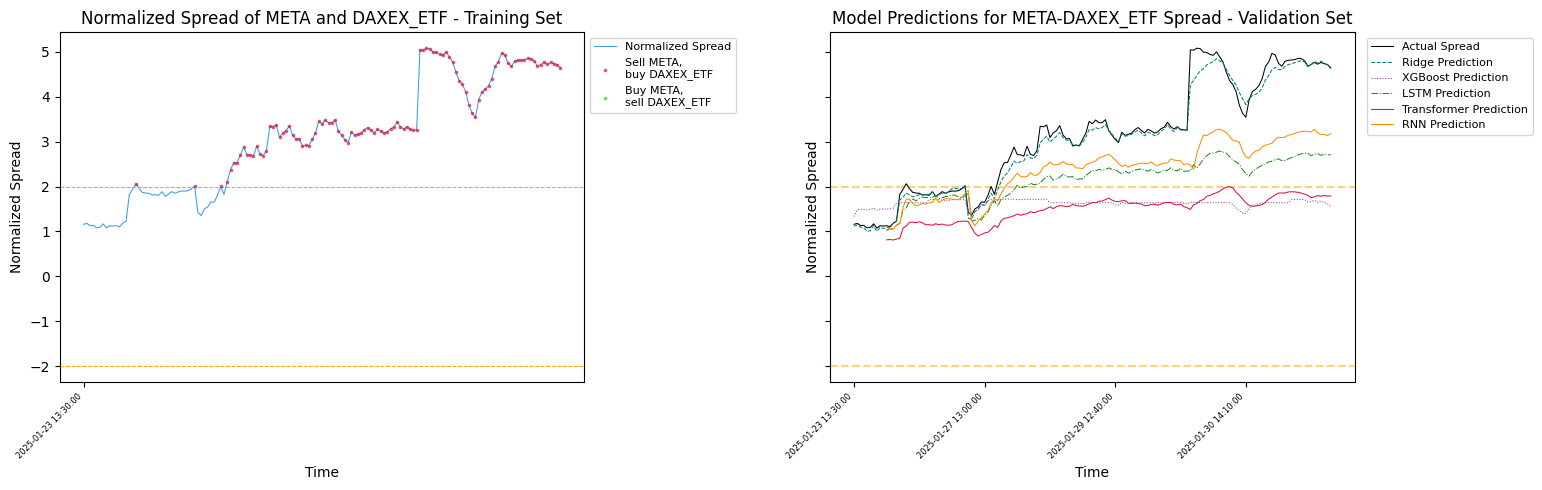

(2) Pairs: AMZN BNBUSDT
# of original features: 26
# of features after LassoCV: 15
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_AMZN_BNBUSDT.pkl]
Ridge Regression MSE: 0.000733
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_BNBUSDT.pkl.
XGBoost MSE: 0.06810876760203599
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_BNBUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM MSE: 0.0022379578764492244
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_BNBUSD

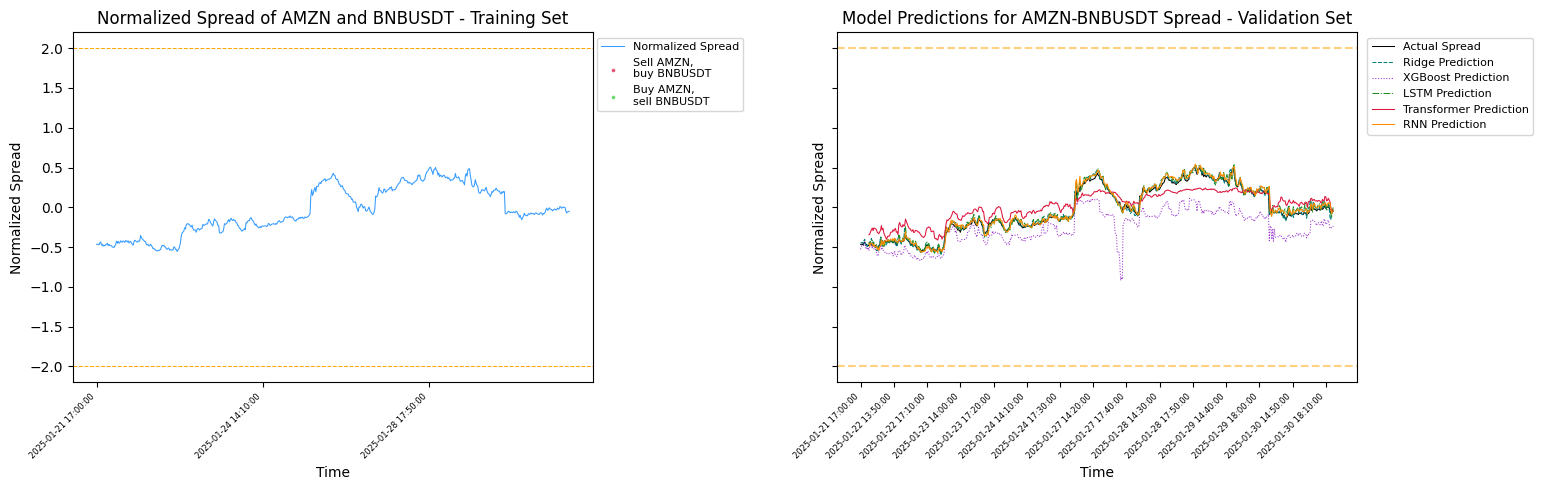

(3) Pairs: AMZN TRXUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_AMZN_TRXUSDT.pkl]
Ridge Regression MSE: 0.000530
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_TRXUSDT.pkl.
XGBoost MSE: 0.07443880571277434
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_TRXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.01409640222289995
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_TRXUSDT.p

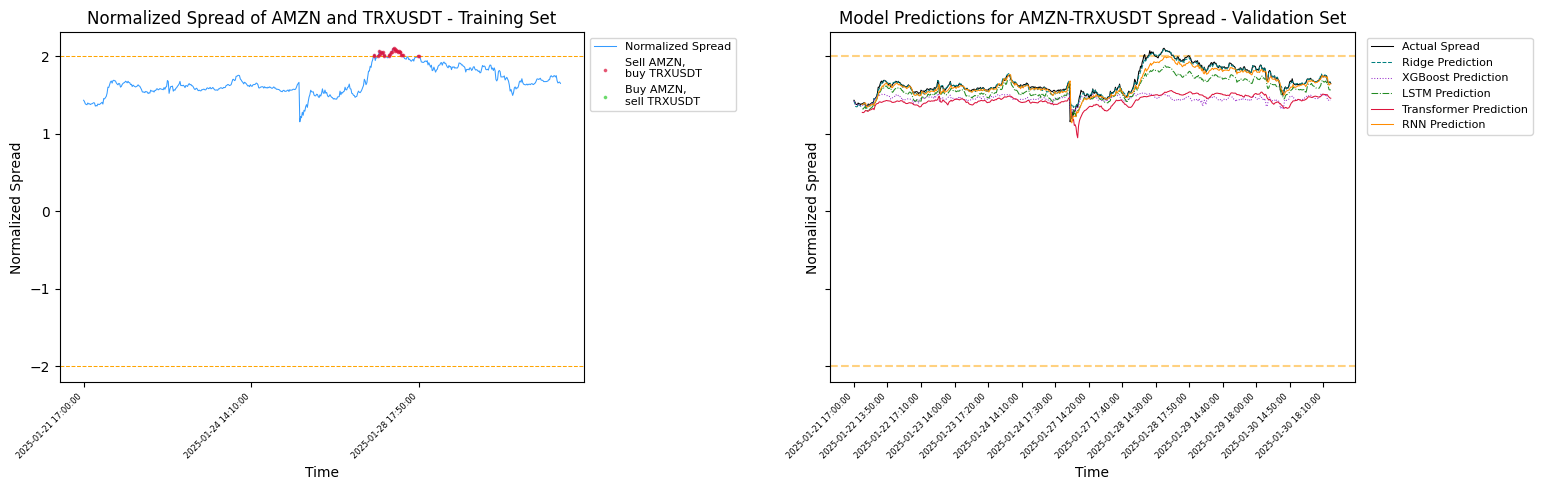

(4) Pairs: SPY_ETF AVAXUSDT
# of original features: 26
# of features after LassoCV: 20
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_SPY_ETF_AVAXUSDT.pkl]
Ridge Regression MSE: 0.004615
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_AVAXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_AVAXUSDT.pkl.
XGBoost MSE: 1.2924078762162794
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_AVAXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_AVAXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.03170280346801484
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn

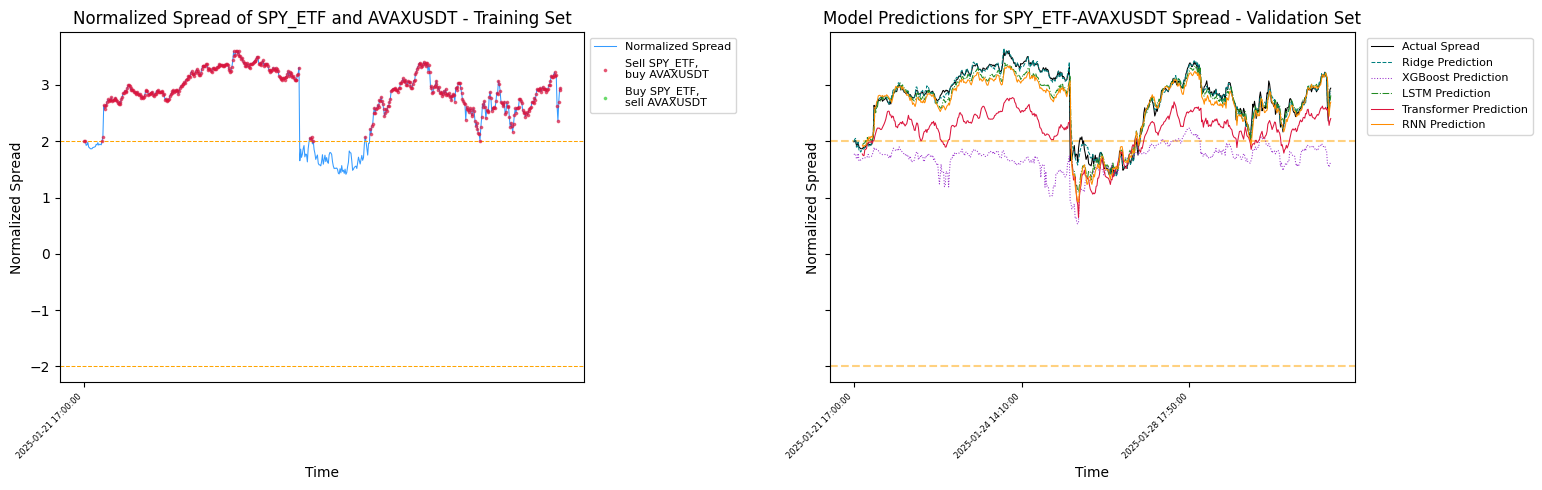

(5) Pairs: SPY_ETF ETHUSDT
# of original features: 26
# of features after LassoCV: 15
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_SPY_ETF_ETHUSDT.pkl]
Ridge Regression MSE: 0.000499
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_ETHUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_ETHUSDT.pkl.
XGBoost MSE: 0.001908850307262789
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_ETHUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_ETHUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM MSE: 0.001471991795548004
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/be

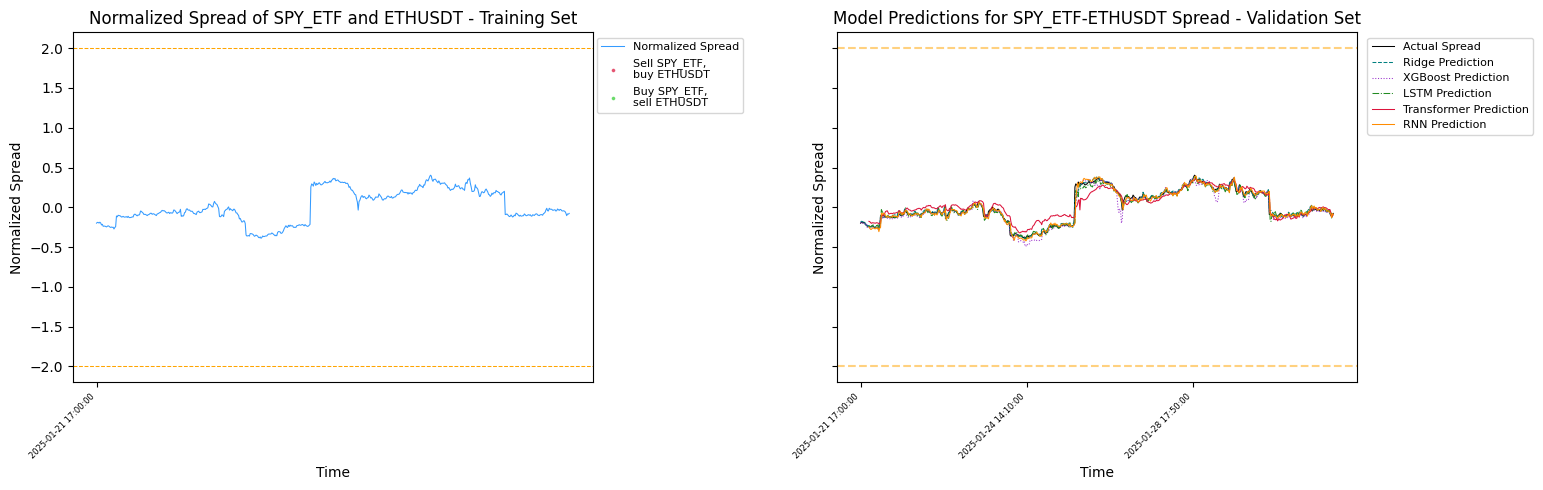

(6) Pairs: EQQQ_ETF BNBUSDT
# of original features: 26
# of features after LassoCV: 12
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_EQQQ_ETF_BNBUSDT.pkl]
Ridge Regression MSE: 0.004354
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_EQQQ_ETF_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_EQQQ_ETF_BNBUSDT.pkl.
XGBoost MSE: 0.11706155451821042
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_EQQQ_ETF_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_EQQQ_ETF_BNBUSDT.pkl.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
LSTM MSE: 0.008196187354756466
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/r

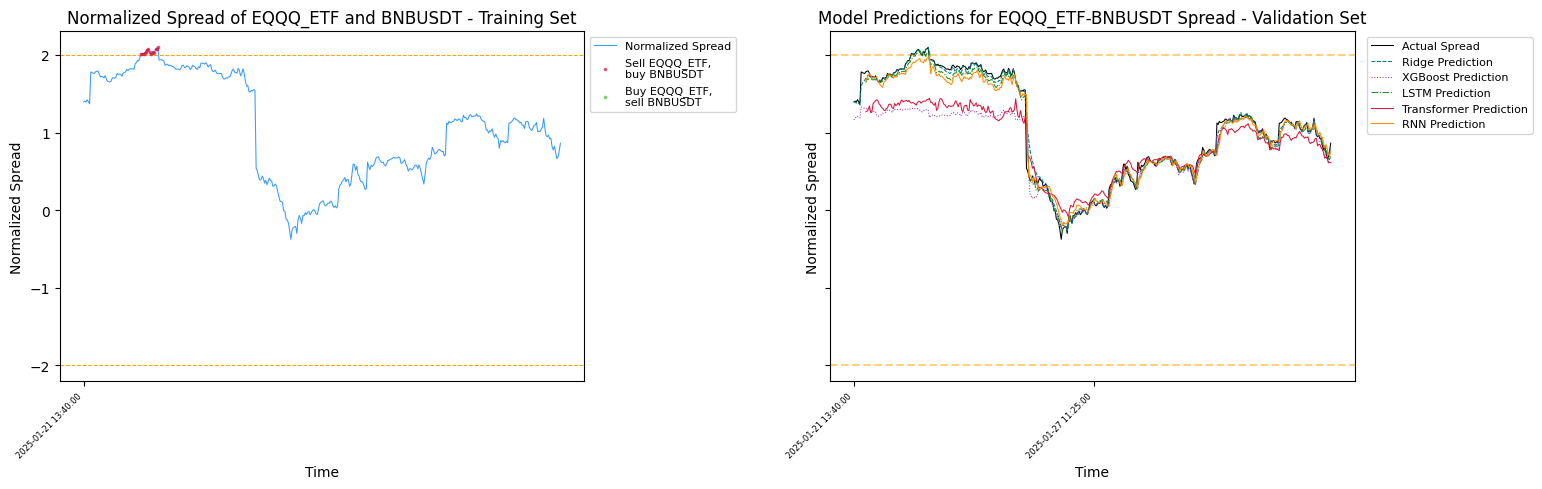

(7) Pairs: BNBUSDT ADAUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_BNBUSDT_ADAUSDT.pkl]
Ridge Regression MSE: 0.000130
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_ADAUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_ADAUSDT.pkl.
XGBoost MSE: 0.000299697717987869
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_ADAUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_ADAUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
LSTM MSE: 0.00030749042148706855
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/

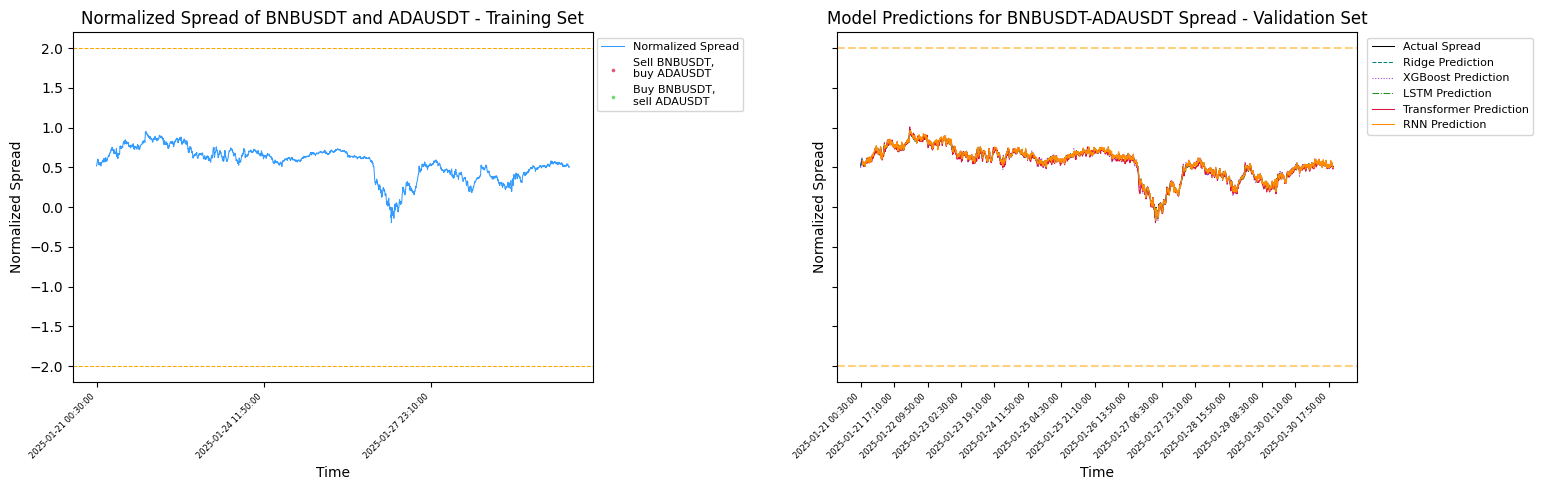

(8) Pairs: BNBUSDT BTCUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_BNBUSDT_BTCUSDT.pkl]
Ridge Regression MSE: 0.000089
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_BTCUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_BTCUSDT.pkl.
XGBoost MSE: 0.00021592171774087842
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_BTCUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_BTCUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
LSTM MSE: 0.0006331060561709597
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn

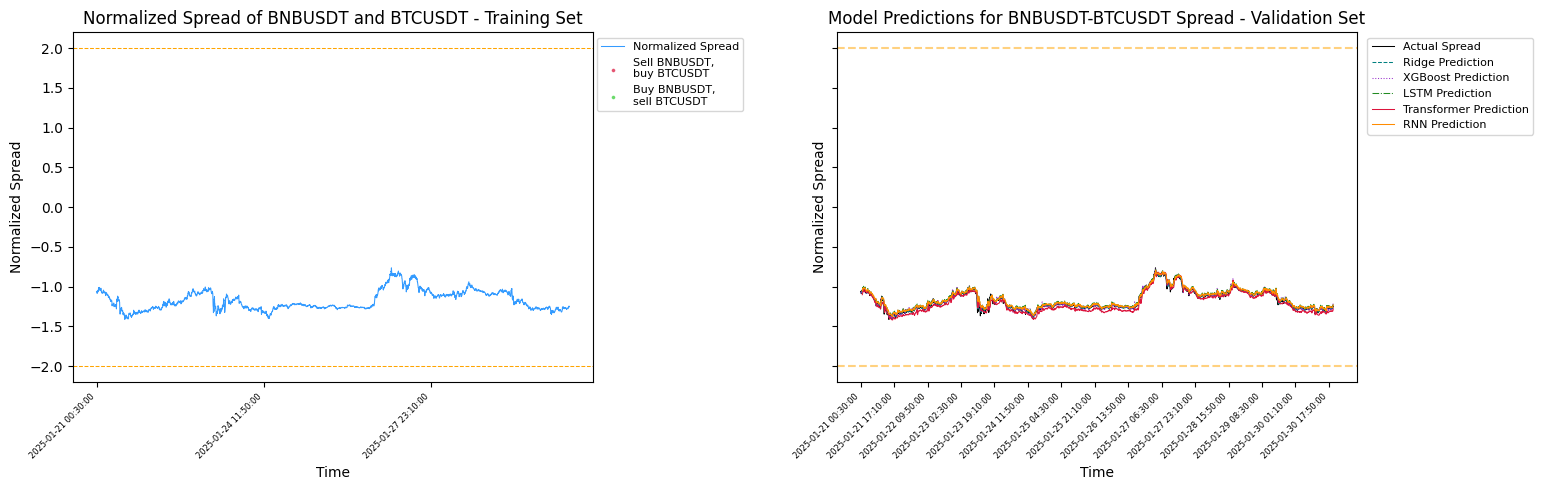

(9) Pairs: BNBUSDT TRXUSDT
# of original features: 26
# of features after LassoCV: 11
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_BNBUSDT_TRXUSDT.pkl]
Ridge Regression MSE: 0.000130
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_TRXUSDT.pkl.
XGBoost MSE: 0.0003402421962623623
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_TRXUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
LSTM MSE: 0.0002722452150282951
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn

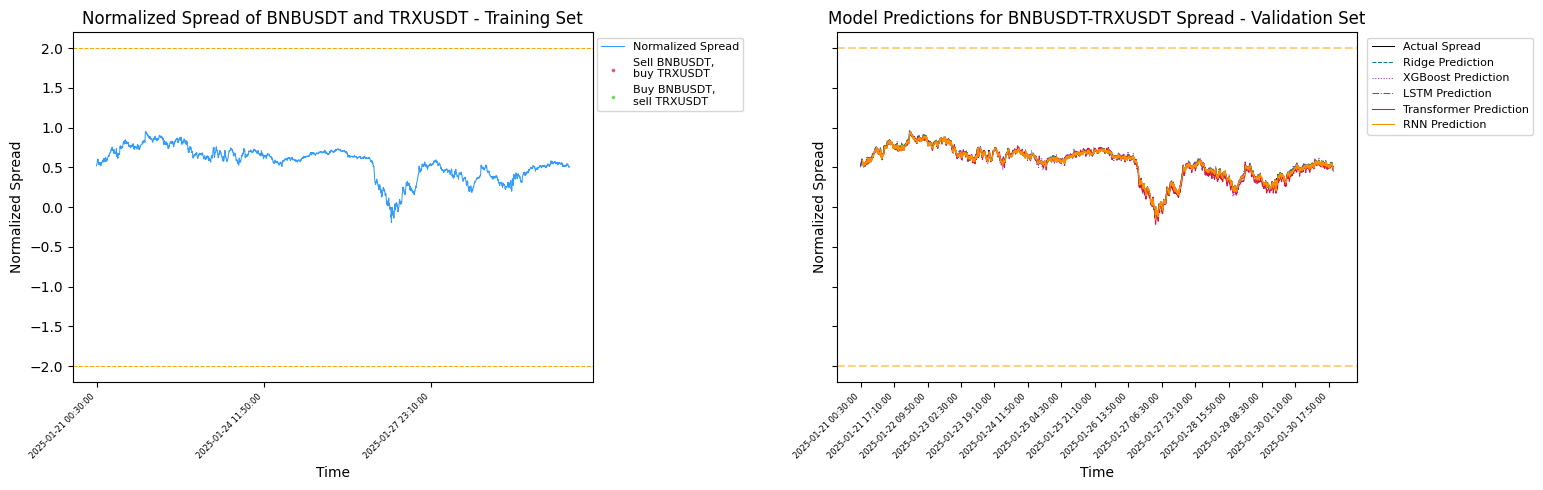

(10) Pairs: BNBUSDT XRPUSDT
# of original features: 26
# of features after LassoCV: 11
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_BNBUSDT_XRPUSDT.pkl]
Ridge Regression MSE: 0.000133
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_XRPUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_XRPUSDT.pkl.
XGBoost MSE: 0.0003033174301571615
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_XRPUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_XRPUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
LSTM MSE: 0.0003515901981896163
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rn

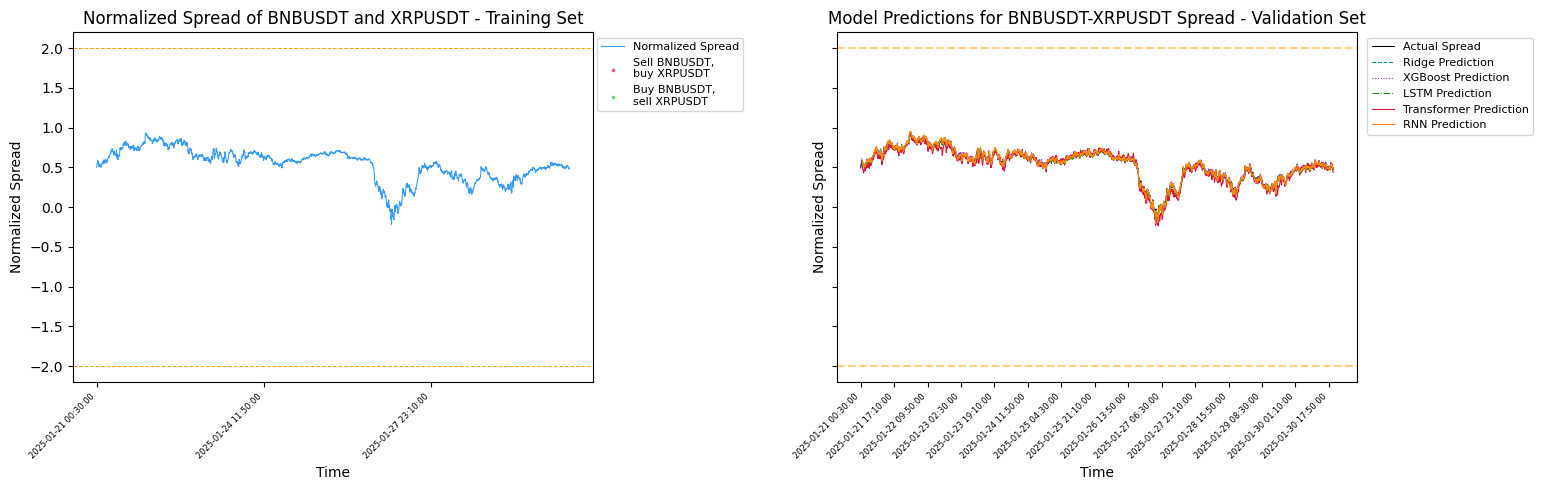

In [17]:
i = 1
verbose = True

tuned_performance = []
best_validation_dfs = pd.DataFrame()
s = 2.0

for p in pairs:
    print(f"({i}) Pairs: {p}")
    tickerX, tickerY = p.split(' ')

    # 1. Read normalized features
    df_norm = dict_data['df_norm'][p]
    print(f'# of original features: {len(df_norm.columns)-1}')
    
    # 2. Create X, y based on LassoCV
    lasso_features_cols = dict_cv_features[p]
    target_col = df_norm.columns.tolist()[-1]
    df_lasso = pd.concat([df_norm[lasso_features_cols], df_norm[target_col]], axis=1)
    print(f'# of features after LassoCV: {len(df_lasso.columns)-1}')

    # 3. Load train models and running the trainning process
    ridge, ridge_mse, ridge_test_df, ridge_time, ridge_memory = models.ridge_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'ridge', f"best_ridge_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    xgb, xgb_mse, xgb_test_df, xgb_time, xgb_memory = models.xgboost_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'xgb', f"best_xgb_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    lstm, lstm_mse, lstm_test_df, lstm_time, lstm_memory = models.lstm_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'lstm', f"best_lstm_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    rnn, rnn_mse, rnn_test_df, rnn_time, rnn_memory = models.rnn_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'rnn', f"best_rnn_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    trf, trf_mse, trf_test_df, trf_time, trf_memory = models.transformer_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'transformer', f"best_transformer_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    best_validation_dfs = pd.concat([
        best_validation_dfs,
        ridge_test_df.reset_index(),
        xgb_test_df.reset_index(),
        lstm_test_df.reset_index(),
        rnn_test_df.reset_index(),
        trf_test_df.reset_index(),
    ])

    tuned_performance.append({
        'Pair': p,
        'Ridge Test MSE': ridge_mse,
        'Ridge Test Time': ridge_time,
        'Ridge Memory Usage': ridge_memory,
        'XGB Test MSE': xgb_mse,
        'XGB Test Time': xgb_time,
        'XGB Memory Usage': xgb_memory,
        'LSTM Test MSE': lstm_mse,
        'LSTM Test Time': lstm_time,
        'LSTM Memory Usage': lstm_memory,
        'RNN Test MSE': rnn_mse,
        'RNN Test Time': rnn_time,
        'RNN Memory Usage': rnn_memory,
        'Transformer Test MSE': trf_mse,
        'Transformer Test Time': trf_time,
        'Transformer Memory Usage': trf_memory,
    })

    # Plot forecasts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    data.plot_spread(df_norm, tickerX, tickerY, ax=ax1)
    models.plot_model_forecasts(ridge_test_df, xgb_test_df,
                                lstm_test_df, trf_test_df,
                                rnn_test_df, tickerX, tickerY, ax=ax2)

    i += 1
    plt.show()
    # spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')

In [13]:
tuned_performance_df = pd.DataFrame(tuned_performance).set_index('Pair').T
display(tuned_performance_df)

Pair,META DAXEX_ETF,AMZN BNBUSDT,AMZN TRXUSDT,SPY_ETF AVAXUSDT,SPY_ETF ETHUSDT,EQQQ_ETF BNBUSDT,BNBUSDT ADAUSDT,BNBUSDT BTCUSDT,BNBUSDT TRXUSDT,BNBUSDT XRPUSDT
Ridge Test MSE,0.028219,0.000733,0.000530,0.004615,0.000499,0.004354,0.000130,0.000089,0.000130,0.000133
Ridge Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ridge Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB Test MSE,3.645550,0.068109,0.074439,1.292408,0.001909,0.117062,0.000300,0.000216,0.000340,0.000303
XGB Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM Test MSE,1.737260,0.002238,0.014096,0.031703,0.001472,0.008196,0.000307,0.000633,0.000272,0.000352
LSTM Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RNN Test MSE,1.089440,0.001825,0.003636,0.047657,0.001373,0.011237,0.000336,0.000623,0.000286,0.000371


## Trained models (using based models)

(1) Pairs: META DAXEX_ETF
# of original features: 26
# of features after LassoCV: 14
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_META_DAXEX_ETF.pkl]
Ridge Regression MSE: 0.028359
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_META_DAXEX_ETF.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_META_DAXEX_ETF.pkl.
XGBoost MSE: 3.022639072911747
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_META_DAXEX_ETF.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_META_DAXEX_ETF.pkl.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM MSE: 0.6623789089150612
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/base_rnn_META_DA

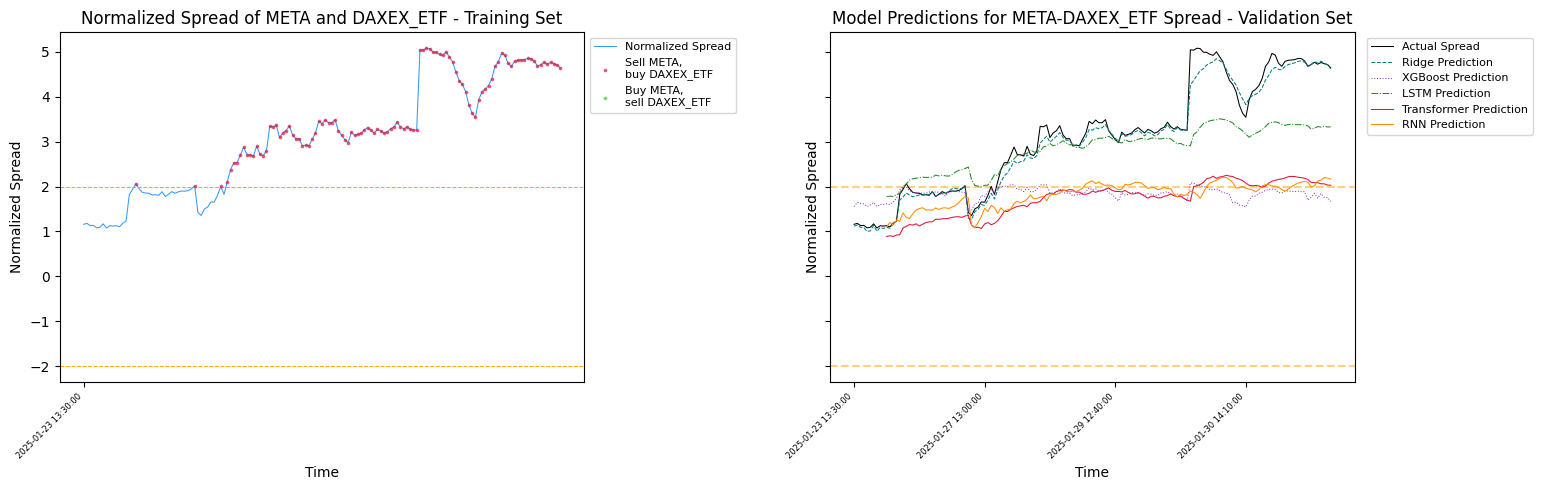

(2) Pairs: AMZN BNBUSDT
# of original features: 26
# of features after LassoCV: 15
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_AMZN_BNBUSDT.pkl]
Ridge Regression MSE: 0.000768
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_AMZN_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_AMZN_BNBUSDT.pkl.
XGBoost MSE: 0.06591978199050973
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_AMZN_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_AMZN_BNBUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM MSE: 0.001437971679154744
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/base_rnn_AMZN_BNBUSDT.

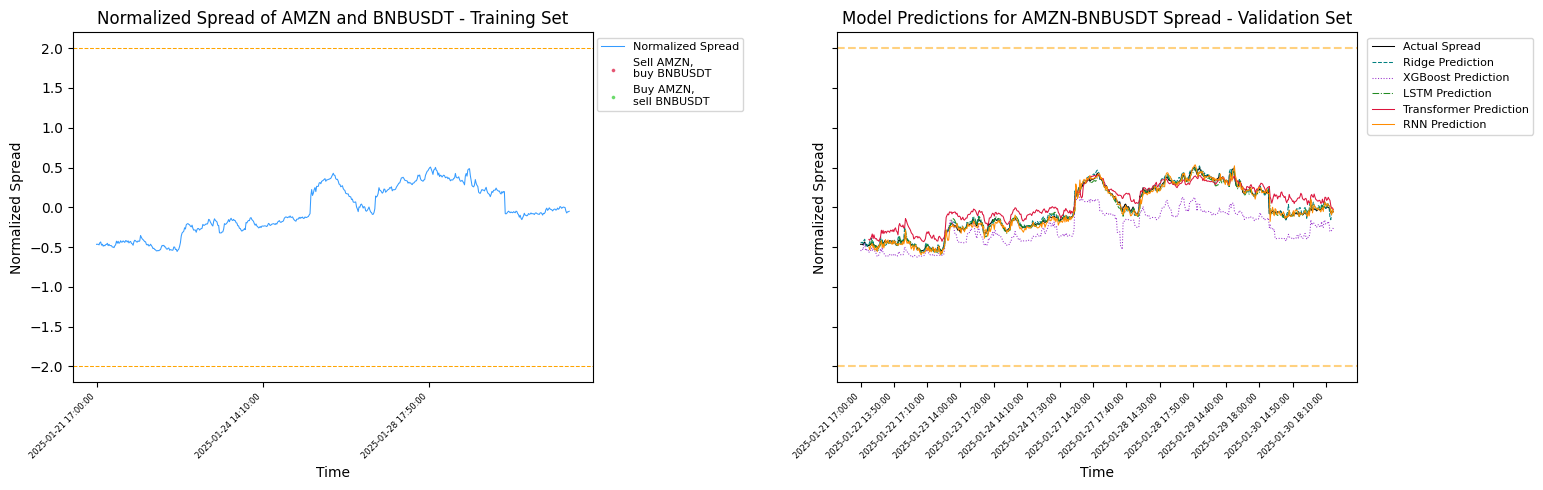

(3) Pairs: AMZN TRXUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_AMZN_TRXUSDT.pkl]
Ridge Regression MSE: 0.000530
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_AMZN_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_AMZN_TRXUSDT.pkl.
XGBoost MSE: 0.07668402519601757
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_AMZN_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_AMZN_TRXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM MSE: 0.0035624451470681667
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/base_rnn_AMZN_TRXUSDT.

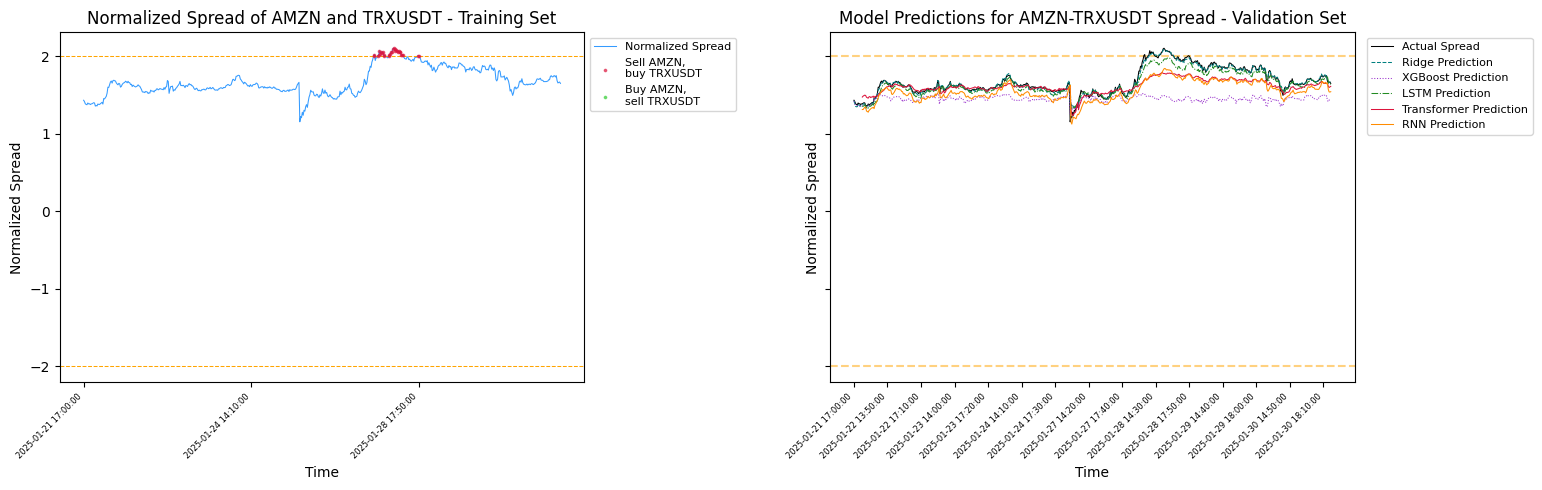

(4) Pairs: SPY_ETF AVAXUSDT
# of original features: 26
# of features after LassoCV: 20
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_SPY_ETF_AVAXUSDT.pkl]
Ridge Regression MSE: 0.005394
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_SPY_ETF_AVAXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_SPY_ETF_AVAXUSDT.pkl.
XGBoost MSE: 1.0629930645458374
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_SPY_ETF_AVAXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_SPY_ETF_AVAXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM MSE: 0.10408402547042624
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/

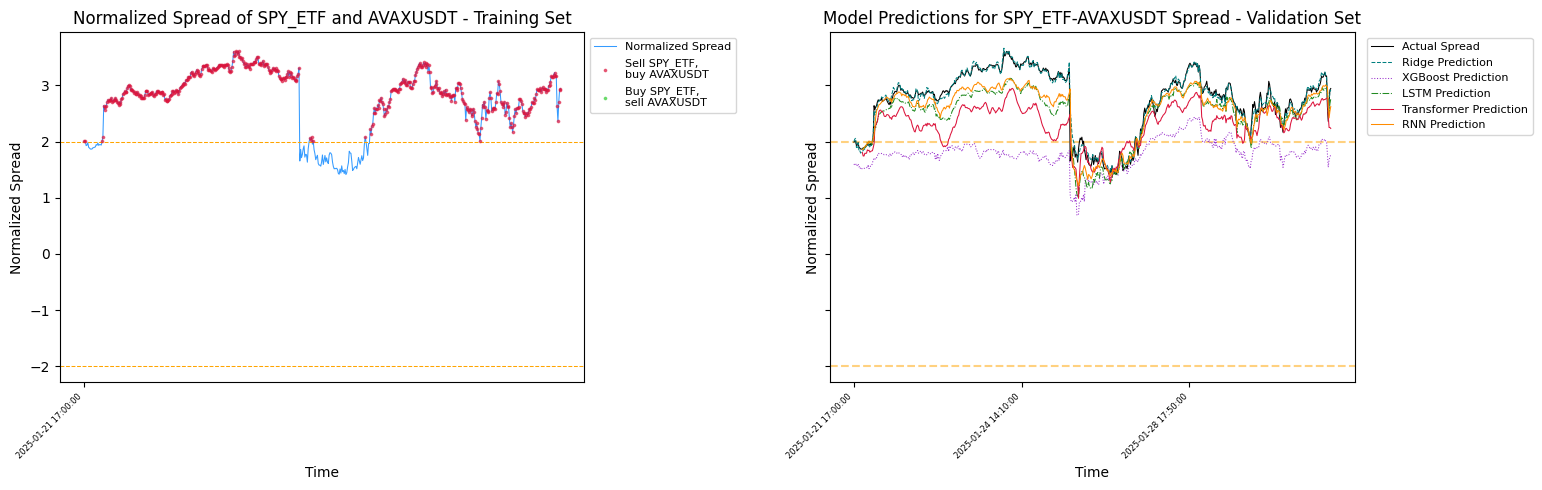

(5) Pairs: SPY_ETF ETHUSDT
# of original features: 26
# of features after LassoCV: 15
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_SPY_ETF_ETHUSDT.pkl]
Ridge Regression MSE: 0.000516
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_SPY_ETF_ETHUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_SPY_ETF_ETHUSDT.pkl.
XGBoost MSE: 0.0013874381409769404
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_SPY_ETF_ETHUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_SPY_ETF_ETHUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM MSE: 0.0017729198919461018
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/b

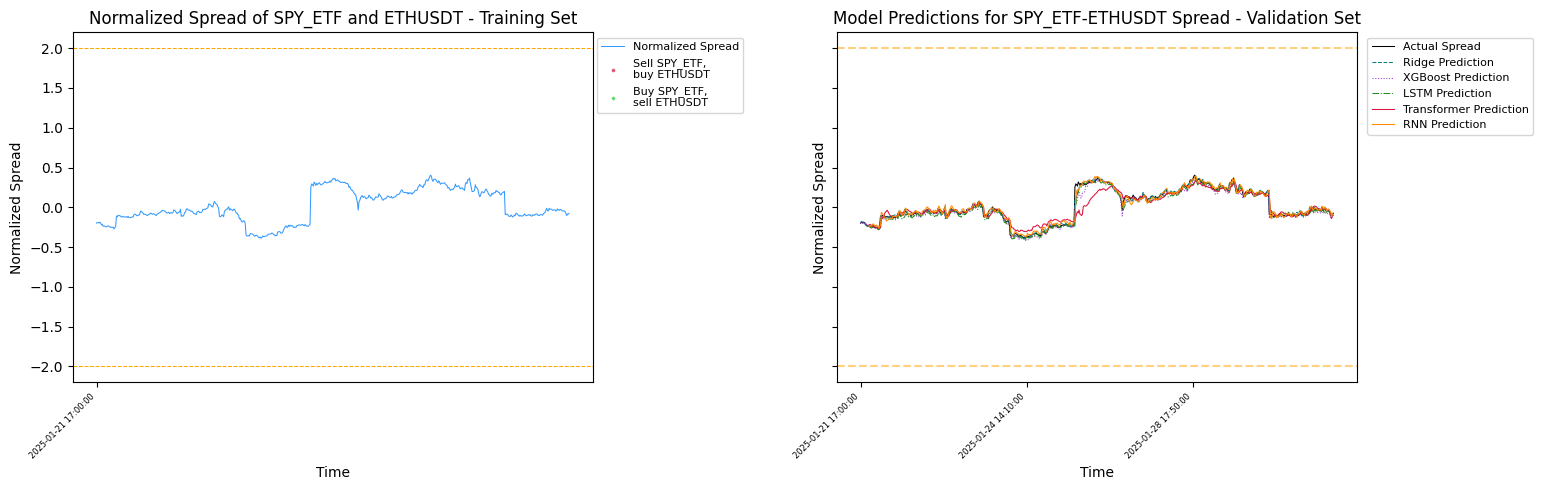

(6) Pairs: EQQQ_ETF BNBUSDT
# of original features: 26
# of features after LassoCV: 12
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_EQQQ_ETF_BNBUSDT.pkl]
Ridge Regression MSE: 0.004876
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_EQQQ_ETF_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_EQQQ_ETF_BNBUSDT.pkl.
XGBoost MSE: 0.12306731474385367
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_EQQQ_ETF_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_EQQQ_ETF_BNBUSDT.pkl.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM MSE: 0.03456984860272528
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn

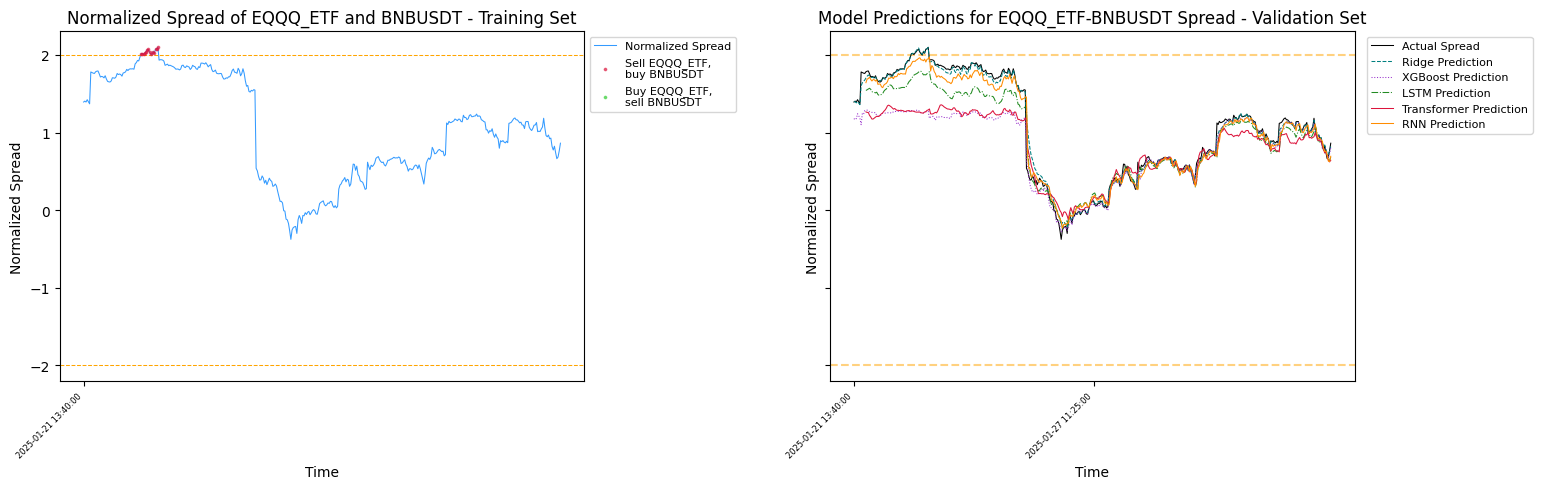

(7) Pairs: BNBUSDT ADAUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_BNBUSDT_ADAUSDT.pkl]
Ridge Regression MSE: 0.000132
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_ADAUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_ADAUSDT.pkl.
XGBoost MSE: 0.00036886378802184736
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_ADAUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_ADAUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM MSE: 0.0006988484055852808
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/b

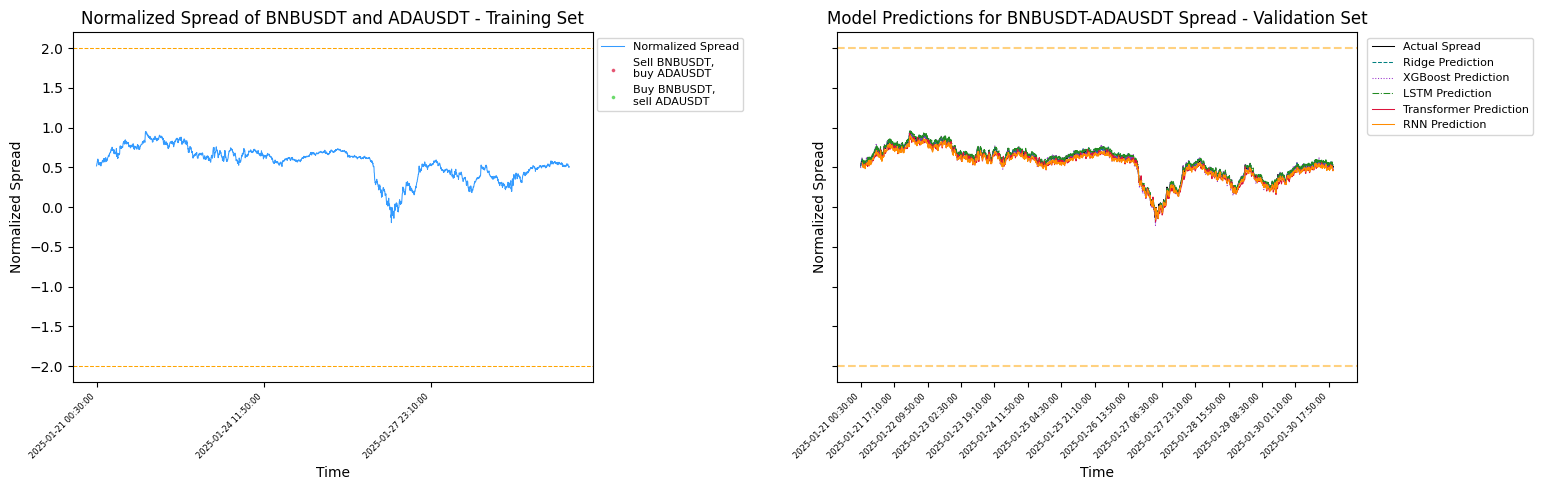

(8) Pairs: BNBUSDT BTCUSDT
# of original features: 26
# of features after LassoCV: 8
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_BNBUSDT_BTCUSDT.pkl]
Ridge Regression MSE: 0.000101
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_BTCUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_BTCUSDT.pkl.
XGBoost MSE: 0.00023539238784049319
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_BTCUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_BTCUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LSTM MSE: 0.0009257502475731896
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/

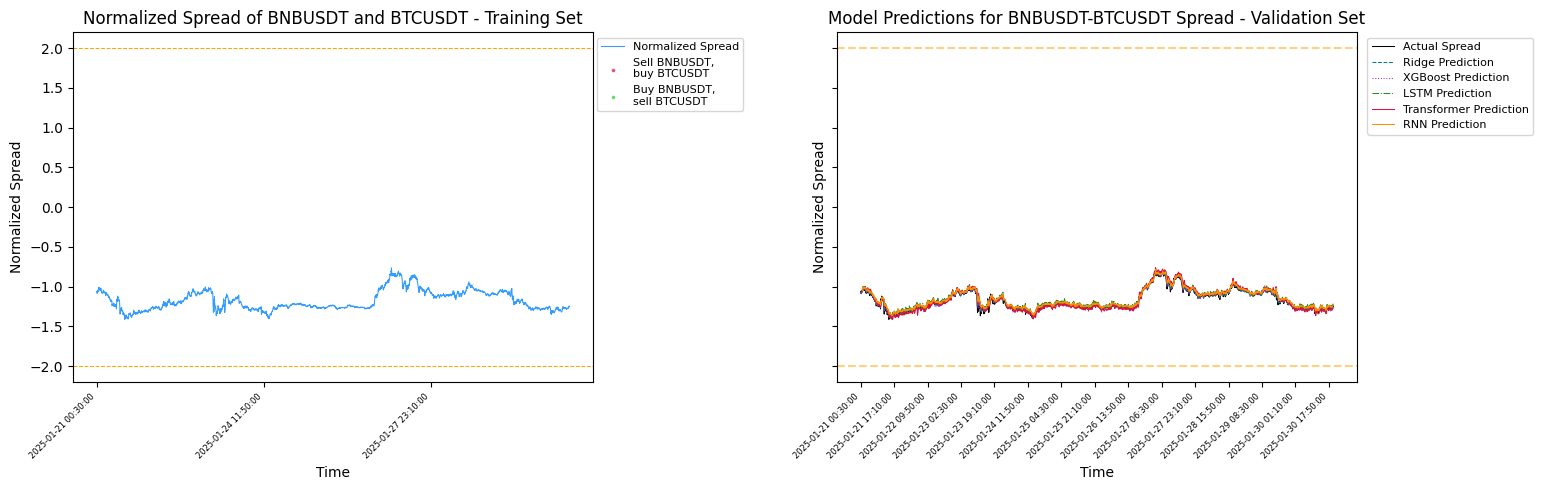

(9) Pairs: BNBUSDT TRXUSDT
# of original features: 26
# of features after LassoCV: 11
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_BNBUSDT_TRXUSDT.pkl]
Ridge Regression MSE: 0.000130
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_TRXUSDT.pkl.
XGBoost MSE: 0.0003658263365932132
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_TRXUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LSTM MSE: 0.0002750567698557495
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rnn/

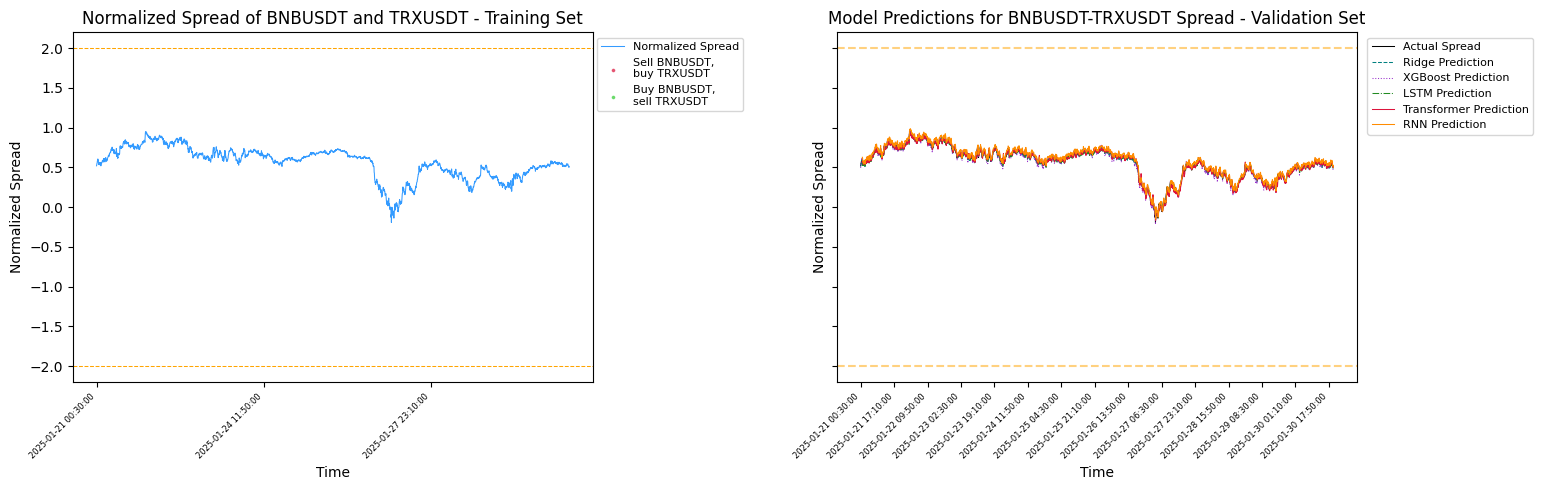

(10) Pairs: BNBUSDT XRPUSDT
# of original features: 26
# of features after LassoCV: 11
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/ridge/base_ridge_BNBUSDT_XRPUSDT.pkl]
Ridge Regression MSE: 0.000133
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_XRPUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/base/xgb/base_xgb_BNBUSDT_XRPUSDT.pkl.
XGBoost MSE: 0.00031554827594170657
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_XRPUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/base/lstm/base_lstm_BNBUSDT_XRPUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
LSTM MSE: 0.0007311846339750672
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/base/rn

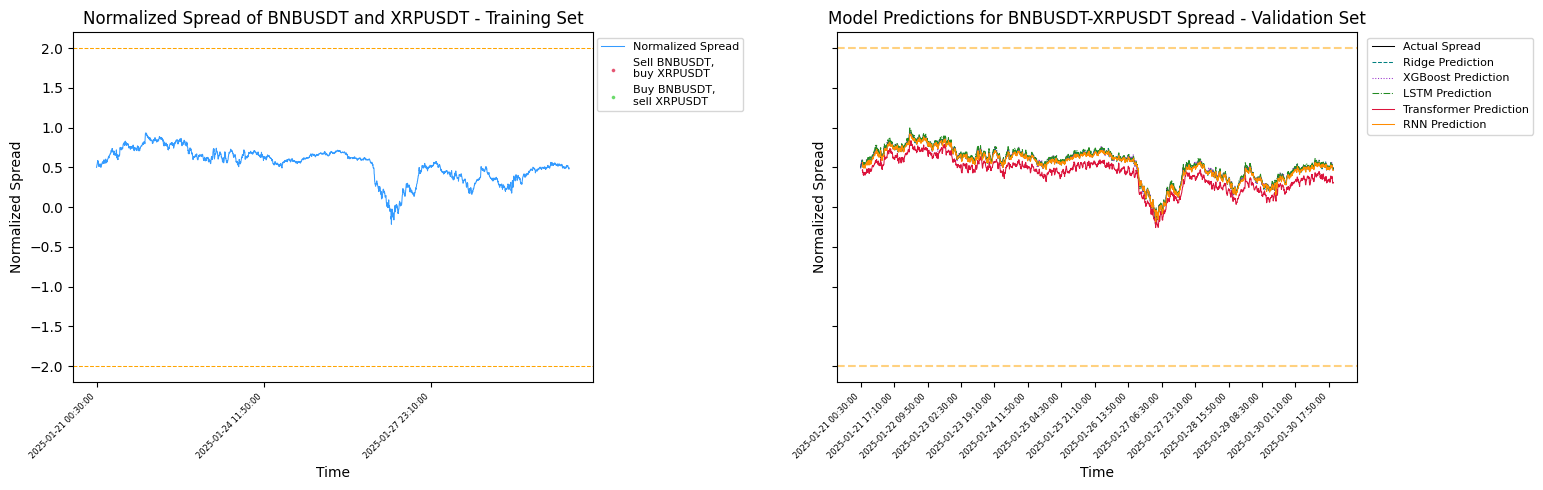

In [14]:
i = 1
verbose = True

untuned_performance = []
base_validation_dfs = pd.DataFrame()
s = 2.0

for p in pairs:
    print(f"({i}) Pairs: {p}")
    tickerX, tickerY = p.split(' ')

    # 1. Read normalized features
    df_norm = dict_data['df_norm'][p]
    print(f'# of original features: {len(df_norm.columns)-1}')
    
    # 2. Create X, y based on LassoCV
    lasso_features_cols = dict_cv_features[p]
    target_col = df_norm.columns.tolist()[-1]
    df_lasso = pd.concat([df_norm[lasso_features_cols], df_norm[target_col]], axis=1)
    print(f'# of features after LassoCV: {len(df_lasso.columns)-1}')

    # 3. Load train models and running the trainning process
    ridge, ridge_mse, ridge_test_df, ridge_time, ridge_memory = models.ridge_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_base, 'ridge', f"base_ridge_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    xgb, xgb_mse, xgb_test_df, xgb_time, xgb_memory = models.xgboost_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_base, 'xgb', f"base_xgb_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    lstm, lstm_mse, lstm_test_df, lstm_time, lstm_memory = models.lstm_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_base, 'lstm', f"base_lstm_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    rnn, rnn_mse, rnn_test_df, rnn_time, rnn_memory = models.rnn_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_base, 'rnn', f"base_rnn_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    trf, trf_mse, trf_test_df, trf_time, trf_memory = models.transformer_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_base, 'transformer', f"base_transformer_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    base_validation_dfs = pd.concat([
        base_validation_dfs,
        ridge_test_df.reset_index(),
        xgb_test_df.reset_index(),
        lstm_test_df.reset_index(),
        rnn_test_df.reset_index(),
        trf_test_df.reset_index(),
    ])

    untuned_performance.append({
        'Pair': p,
        'Ridge Test MSE': ridge_mse,
        'Ridge Test Time': ridge_time,
        'Ridge Memory Usage': ridge_memory,
        'XGB Test MSE': xgb_mse,
        'XGB Test Time': xgb_time,
        'XGB Memory Usage': xgb_memory,
        'LSTM Test MSE': lstm_mse,
        'LSTM Test Time': lstm_time,
        'LSTM Memory Usage': lstm_memory,
        'RNN Test MSE': rnn_mse,
        'RNN Test Time': rnn_time,
        'RNN Memory Usage': rnn_memory,
        'Transformer Test MSE': trf_mse,
        'Transformer Test Time': trf_time,
        'Transformer Memory Usage': trf_memory,
    })

    # Plot forecasts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    data.plot_spread(df_norm, tickerX, tickerY, ax=ax1)
    models.plot_model_forecasts(ridge_test_df, xgb_test_df,
                                lstm_test_df, trf_test_df,
                                rnn_test_df, tickerX, tickerY, ax=ax2)

    i += 1
    plt.show()
    # spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')

In [15]:
untuned_performance_df = pd.DataFrame(untuned_performance).set_index('Pair').T
display(untuned_performance_df)

Pair,META DAXEX_ETF,AMZN BNBUSDT,AMZN TRXUSDT,SPY_ETF AVAXUSDT,SPY_ETF ETHUSDT,EQQQ_ETF BNBUSDT,BNBUSDT ADAUSDT,BNBUSDT BTCUSDT,BNBUSDT TRXUSDT,BNBUSDT XRPUSDT
Ridge Test MSE,0.028359,0.000768,0.000530,0.005394,0.000516,0.004876,0.000132,0.000101,0.000130,0.000133
Ridge Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ridge Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB Test MSE,3.022639,0.065920,0.076684,1.062993,0.001387,0.123067,0.000369,0.000235,0.000366,0.000316
XGB Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM Test MSE,0.662379,0.001438,0.003562,0.104084,0.001773,0.034570,0.000699,0.000926,0.000275,0.000731
LSTM Test Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RNN Test MSE,2.943043,0.001763,0.020993,0.069224,0.001492,0.010769,0.001568,0.000807,0.000976,0.000367
